# Data analysis and Forecasting of fuel prices in Germany
## Project Overview
The fuel price is like the stock prices changing heavily on a day, but mostly not with the same amplitude. But even if you have a look on a day by day base, there are many up and downs. Therefore I want to have a look at the data and see what’s inside. Furthermore I want to build a forecasting model for the price on daily base. I’ll choose this as capstone project to become familiar with time series data and also forecasting model ARIMA.
The history of all fuel stations in Germany is available from Tankerkoenig.de at https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data for private use under following license https://creativecommons.org/licenses/by-nc-sa/4.0/ .

I’ll will follow the CRISP-DM:
1. **Business understanding**
How to handle time series data?
When it is good time for refueling to save money?
How to prepare the data for building model?
How well the model can forecast the fuel price for next days?
2. **Data Understanding**
This is done in the chapter Data Exploration and Data Visualization. There I’ve found also answers to the first two questions.
3. **Prepare Data**
The preparation of data is made in chapter Data PreProcessing, but some preparations was also done before in Data Exploration.
4. **Model Data**
Chapter Implementation builds the model.
5. **Results**
The results and answers of the questions good be found in this blog post. The discussion on the forecasting model can be found in chapter model evaluation and validation.
6. **Deploy**
In this project I did not make a deployment to get the model in production, but I’ll use the findings for building forecast models in the future. Also this work help me to handle time series.

All necessary information about libraries and so on are in the Readme.md in the github(https://github.com/klogges5/capstone) repository.

## Problem statement
- How to handle time series data?
- Does the data have other useful insights? 
- When it is good time for refueling to save money?
- How to prepare the data for building models?
- Could I find a model to forecast the fuel price?

Therefore I’ll have a look at the history data(2015-2019). For handling the amount of data I’ll first reduced it to zip codes starting with 40. This leads to a 250 MB sql file. Because github is only storing 100 MB I’ll reduced it further to 8 stations.
First I’ll have a look at the data and see what is in. Therefore I’ll use some plot functions to find some insights. For forecast model I’ll use the SARIMAX from (Seabold, 2010) and will build the model based on ACF/PACF. Even it is not necessary in capstone project to use 2 models, I’ll have a look also on LSTM as a forecast model.



In [1]:
import datetime
import pandas as pd
import glob
import numpy as np
from sqlalchemy import create_engine
from helper_functions import save_data, load_data, get_data4uid
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, LSTM
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pylab import rcParams
from helper_functions import load_data, get_data4uid

rcParams['figure.figsize'] = (15, 8)

# use prefix for Mac 'Volumes/JMVB' or Windows 'e:/Working'
prefix='/Volumes/JMVB'

Using TensorFlow backend.


## Reading the stations

First load the file `stations.csv` to see what is inside. Therefore i loaded a stations file of the last month. Here a short description of the information inside:

`uuid,name,brand,street,house_number,post_code,city,latitude,longitude, first_active, openingtimes_json`



In [2]:
# change the directory as necessary
stations_pd = pd.read_csv(prefix+'/sprit/stations.csv')

In [3]:
stations_pd.head()

uuid                     name brand  \
0  ad812258-94e7-473d-aa80-d392f7532218   bft Bonn-Bad Godesberg   bft   
1  44e2bdb7-13e3-4156-8576-8326cdd20459           bft Tankstelle   NaN   
2  0e18d0d3-ed38-4e7f-a18e-507a78ad901d  OIL! Tankstelle München  OIL!   
3  db0655ed-4b94-4c12-a75d-26b2d6a38759    AVIA Albstadt-Ebingen  AVIA   
4  6a625a13-310c-43fb-8316-4e8027a54510          Aral Tankstelle  ARAL   

                street house_number post_code      city   latitude  longitude  \
0    Godesberger Allee           55     53175      Bonn  50.695100   7.142760   
1       Schellengasse            53     36304   Alsfeld  50.752010   9.279039   
2  Eversbuschstraße 33          NaN     80999   München  48.180700  11.460900   
3     Lautlinger Str.             3     72458  Albstadt  48.212800   9.012450   
4     Leipziger Straße          208     08058   Zwickau  50.742687  12.488169   

             first_active                                  openingtimes_json  
0  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":32,"period...  
1  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":63,"period...  
2  1970-01-01 01:00:00+01  {"openingTimes":[{"applicable_days":63,"period...  
3  2014-03-18 16:45:31+01  {"openingTimes":[{"applicable_days":63,"period...  
4  2014-03-18 16:45:31+01                                                 {}

In [4]:
stations_pd.shape

(15859, 11)

In [5]:
stations_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15859 entries, 0 to 15858
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   uuid               15859 non-null  object 
 1   name               15859 non-null  object 
 2   brand              15243 non-null  object 
 3   street             15856 non-null  object 
 4   house_number       12014 non-null  object 
 5   post_code          15856 non-null  object 
 6   city               15855 non-null  object 
 7   latitude           15859 non-null  float64
 8   longitude          15859 non-null  float64
 9   first_active       15859 non-null  object 
 10  openingtimes_json  15859 non-null  object 
dtypes: float64(2), object(9)
memory usage: 1.3+ MB


In [6]:
# want to see all stations around zip-code 40xxx
short_pd = stations_pd.dropna(subset=['post_code'])
short_pd = short_pd[short_pd['post_code'].str.match(pat = '40\d{3}')]

## Reading Prices

The prices are organized in folders for every year and month and is really big data (around 5 GB per year). Therefore i've build a function to load the Data per year and extract only a few data for stations in short_pd. The pricesxxx.csv are in the following format:

`date,station_uuid,diesel,e5,e10,dieselchange,e5change,e10change`

In [7]:
# let's read one file to see special cases or wrong data
prices_tmp = pd.read_csv(prefix + '/sprit/2015/01/2015-01-01-prices.csv', usecols=['date', 'station_uuid', 'diesel', 'e5', 'e10'])

In [8]:
prices_tmp.head()

date                          station_uuid  diesel  \
0  2015-01-01 00:02:01+01  00060151-0001-4444-8888-acdc00000001   1.189   
1  2015-01-01 00:02:01+01  005056ba-7cb6-1ed2-bceb-6e6ee17d4d20   1.179   
2  2015-01-01 00:02:01+01  139897a8-a161-4f4c-b550-bca985affa38   1.159   
3  2015-01-01 00:02:01+01  18aef2d2-ed53-44d2-9f7f-512f994593c2   1.219   
4  2015-01-01 00:02:01+01  3e7c0f12-9665-40e2-7c70-d0dfb19314cd   1.229   

      e5    e10  
0  1.329  1.289  
1  1.319  1.279  
2  1.299  1.259  
3  1.359  1.319  
4  1.369  1.329

In [9]:
prices_tmp.describe()

diesel            e5           e10
count  53868.000000  53868.000000  53868.000000
mean       1.181945      1.292544      1.256904
std        0.051318      0.221374      0.215966
min       -0.001000     -0.001000     -0.001000
25%        1.149000      1.289000      1.259000
50%        1.179000      1.329000      1.289000
75%        1.219000      1.359000      1.329000
max        2.015000      2.015000      2.015000

In [10]:
prices_tmp[~(prices_tmp.diesel < 0.5)].describe()

diesel            e5           e10
count  53853.000000  53853.000000  53853.000000
mean       1.182274      1.292632      1.256990
std        0.047381      0.221122      0.215722
min        1.009000     -0.001000     -0.001000
25%        1.149000      1.289000      1.259000
50%        1.179000      1.329000      1.289000
75%        1.219000      1.359000      1.329000
max        2.015000      2.015000      2.015000

Min Price of -0.001 is not a real value, so i will replace it with np.nan. Furthermor 2.015 € for all types are max? Let's have a look at this also...

In [11]:
prices_tmp[prices_tmp.diesel > 1.70].head()

date                          station_uuid  diesel  \
24  2015-01-01 00:06:01+01  42d6d4cc-6909-45fc-f60f-a1abd9ea1f0e   2.015   

       e5    e10  
24  2.015  2.015

In [12]:
prices_tmp[prices_tmp['station_uuid'] == '42d6d4cc-6909-45fc-f60f-a1abd9ea1f0e']

date                          station_uuid  diesel  \
24  2015-01-01 00:06:01+01  42d6d4cc-6909-45fc-f60f-a1abd9ea1f0e   2.015   

       e5    e10  
24  2.015  2.015

It seems like this station has made an joke for new year ;-) This dataset will be removed later, after all prices are read, because i will focus on some stations only. 

In [13]:
# let's read another file to see special cases or wrong data

prices_tmp = pd.read_csv(prefix + '/sprit/2016/01/2016-01-01-prices.csv', usecols=['date', 'station_uuid', 'diesel', 'e5', 'e10'])

In [14]:
prices_tmp.describe()

diesel            e5           e10
count  85708.000000  85708.000000  85708.000000
mean       1.034316      1.256426      1.236780
std        0.053128      0.209600      0.207974
min       -0.001000     -0.001000     -0.001000
25%        0.999000      1.249000      1.229000
50%        1.029000      1.279000      1.259000
75%        1.059000      1.309000      1.289000
max        2.028000      1.619000      2.000000

There is also a min of -0.01 € and a questionable price of 2.028 € as max for diesel? The max for e5 is only 1.619 € and normally the diesel price is cheaper in Germany, than e5 or e10.

I will do a cleaning of all prices and drop all that are below 0.5 €, because the price wasn't so low in the past.

In [15]:
prices_tmp[(prices_tmp.diesel <= 1.70) & (prices_tmp.diesel > 0.5)].describe()

diesel            e5           e10
count  85691.000000  85691.000000  85691.000000
mean       1.034498      1.256527      1.236836
std        0.051106      0.209312      0.207822
min        0.908000     -0.001000     -0.001000
25%        0.999000      1.249000      1.229000
50%        1.029000      1.279000      1.259000
75%        1.059000      1.309000      1.289000
max        1.269000      1.619000      2.000000

### Reading and cleaning data

In the above examples i've found some wrong data in this two files. After reading the whole dataset i'll have a look on the statistics to see what can be dropped.

In [16]:

def read_data_year(year, filepath):
    '''
    read all relevant data for year x
    Input: year, filepath with 
    Output: dataframe with all prices for region 40x and year
    '''
    print('Read year {}'.format(year))
    
    files = glob.glob('{}{}/*/*'.format(filepath, year))
    prices = [pd.read_csv(file, usecols=['date', 'station_uuid', 'diesel', 'e5', 'e10']) for file in files]
    prices_pd = pd.concat(prices, sort=False)
    data_pd = prices_pd[prices_pd['station_uuid'].isin(short_pd['uuid'])][['date', 'station_uuid', 'diesel', 'e5', 'e10']]
    return data_pd

def read_data(filepath='e:/Working/sprit/'):
    '''
    read all data and make some conversions
    Input: filepath to input files, default is given
    Output: dataframe with datetimeindex and station_uuid as category
    '''
    prices = read_data_year('2015', filepath)
    prices = prices.append(read_data_year('2016', filepath))
    prices = prices.append(read_data_year('2017', filepath))
    prices = prices.append(read_data_year('2018', filepath))
    prices = prices.append(read_data_year('2019', filepath))

    # replace wrong data (<0.5 here for small) with nan 
    prices['diesel'] = prices['diesel'].apply(lambda x: np.nan if x < 0.5 else x)
    prices['e5'] = prices['e5'].apply(lambda x: np.nan if x < 0.5 else x)
    prices['e10'] = prices['e10'].apply(lambda x: np.nan if x < 0.5 else x)
    # make uuid as category 
    prices.station_uuid = prices.station_uuid.astype('category')
    # date should be datetime
    prices.date = pd.to_datetime(prices.date, utc=True)
    return prices

In [17]:
# Reading of all relevant data
prices_pd = read_data(prefix + '/sprit/')

Read year 2015
Read year 2016
Read year 2017
Read year 2018
Read year 2019


In [18]:
prices_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2677793 entries, 74 to 248042
Data columns (total 5 columns):
 #   Column        Dtype              
---  ------        -----              
 0   date          datetime64[ns, UTC]
 1   station_uuid  category           
 2   diesel        float64            
 3   e5            float64            
 4   e10           float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(3)
memory usage: 107.3 MB


In [19]:
prices_pd.describe()

diesel            e5           e10
count  2.676682e+06  2.674904e+06  2.654523e+06
mean   1.193693e+00  1.387779e+00  1.363561e+00
std    9.971780e-02  8.483290e-02  8.389918e-02
min    8.790000e-01  9.090000e-01  1.029000e+00
25%    1.129000e+00  1.329000e+00  1.309000e+00
50%    1.199000e+00  1.379000e+00  1.359000e+00
75%    1.259000e+00  1.449000e+00  1.429000e+00
max    8.888000e+00  2.918000e+00  2.878000e+00

The max values of the fuel types differs too much from the 75% percentile, the values are probable not useful. Let's see which values we can set to NaN. I'll found from looking into the data following values useful.

In [20]:
prices_pd[prices_pd.diesel > 1.7]

date                          station_uuid  \
36871  2015-04-26 12:46:01+00:00  005056ba-7cb6-1ed2-bceb-7e82e4910d2a   
30833  2015-07-16 08:06:01+00:00  ee34d5a4-be1a-2a3a-e040-0b0a3dfe5d3f   
33012  2015-07-16 08:26:01+00:00  ee34d5a4-be1a-2a3a-e040-0b0a3dfe5d3f   
55772  2015-07-16 10:42:01+00:00  ee34d5a4-be1a-2a3a-e040-0b0a3dfe5d3f   
8513   2016-02-08 05:34:01+00:00  67765d63-fec8-4545-9c09-940ea88a8566   
116369 2019-03-25 13:41:06+00:00  b253485f-535c-4554-ba4e-9c2c7093b8cc   
181207 2019-04-13 15:51:06+00:00  b253485f-535c-4554-ba4e-9c2c7093b8cc   
46421  2019-08-02 06:53:05+00:00  09ee977e-c04e-4db1-98bf-b507b123423c   
51459  2019-11-05 08:05:04+00:00  b253485f-535c-4554-ba4e-9c2c7093b8cc   

        diesel     e5    e10  
36871    2.458  2.918  2.878  
30833    8.888  1.469  1.449  
33012    8.888  1.429  1.409  
55772    8.888  1.459  1.439  
8513     1.979  1.239  1.219  
116369   1.999  1.339  1.319  
181207   1.999  1.399  1.379  
46421    1.999  1.399  1.379  
51459    1.779  1.339  1.319

In [21]:
prices_pd[prices_pd.e10 > 1.75]

date                          station_uuid  diesel  \
36871 2015-04-26 12:46:01+00:00  005056ba-7cb6-1ed2-bceb-7e82e4910d2a   2.458   

          e5    e10  
36871  2.918  2.878

In [22]:
prices_pd[prices_pd.e5 > 1.82]

date                          station_uuid  diesel  \
36871 2015-04-26 12:46:01+00:00  005056ba-7cb6-1ed2-bceb-7e82e4910d2a   2.458   
43036 2016-03-24 09:47:02+00:00  09ee977e-c04e-4db1-98bf-b507b123423c   0.969   

          e5    e10  
36871  2.918  2.878  
43036  1.889  1.169

In [23]:
prices_pd['diesel'] = prices_pd['diesel'].apply(lambda x: np.nan if x > 1.7 else x)
prices_pd['e10'] = prices_pd['e10'].apply(lambda x: np.nan if x > 1.75 else x)
prices_pd['e5'] = prices_pd['e5'].apply(lambda x: np.nan if x > 1.82 else x)

In [24]:
prices_pd.isna().sum()

date                0
station_uuid        0
diesel           1120
e5               2891
e10             23271
dtype: int64

In [25]:
#drop all rows where all fuel values are NaN
prices_pd.dropna(axis=0, how='all', subset=['diesel', 'e5', 'e10'], inplace=True)

In [26]:
prices_pd.isna().sum()

date                0
station_uuid        0
diesel            948
e5               2719
e10             23099
dtype: int64

In [27]:
prices_pd.describe()

diesel            e5           e10
count  2.676673e+06  2.674902e+06  2.654522e+06
mean   1.193682e+00  1.387779e+00  1.363561e+00
std    9.937624e-02  8.482722e-02  8.389405e-02
min    8.790000e-01  9.090000e-01  1.029000e+00
25%    1.129000e+00  1.329000e+00  1.309000e+00
50%    1.199000e+00  1.379000e+00  1.359000e+00
75%    1.259000e+00  1.449000e+00  1.429000e+00
max    1.639000e+00  1.819000e+00  1.719000e+00

Now the data looks homogenous and we can save it to the sqllite database. The NaNs will be handled later, because i'll use only daily means for my forecasting model, most of them will go away.

### Run the next cell only to reduce data set

In [28]:
# for reducing the data to upload it in github, i'll choose only 8 stations

uuids = ['005056ba-7cb6-1ed2-bceb-82ea369c0d2d', '79fb1f24-bebb-489e-841f-728f9053b555', '51d4b59c-a095-1aa0-e100-80009459e03a', '005056ba-7cb6-1ed2-bceb-a46e32000d3e', 
         'e43c09b0-5baa-4738-962a-c94388e93c30', '82119d5d-775f-42af-ac56-000d7c91413f', 'e7807347-796f-4aac-997d-07d0c988e109', '5bf85d09-ea6b-4146-b23f-4b902e2e1554']

prices_pd = prices_pd[prices_pd['station_uuid'].isin(uuids)][['date', 'station_uuid', 'diesel', 'e5', 'e10']]


### Save the data to sqllite file, it will overwrite the tables

In [29]:
# uncomment and run this cell only if you read new csv files, it will overwrite the sql file 

#save_data(prices_pd, 'Prices', './Data/prices_40.sql')
#save_data(stations_pd, 'Stations', './Data/prices_40.sql')

# Data Analysis

If you didn't load the raw data from [Tankerkoenig](https://dev.azure.com/tankerkoenig/_git/tankerkoenig-data) you can start here with loading the data from sqllite database.
Here i will have a look at some interesting points out of the data.

In [30]:
# uncomment next line and run this cell to load data from sql file
prices_pd, stations_pd = load_data('./Data/prices_40.sql')

In [31]:
prices_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168058 entries, 2566 to 247406
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   date          168058 non-null  datetime64[ns, UTC]
 1   station_uuid  168058 non-null  category           
 2   diesel        167732 non-null  float64            
 3   e5            168057 non-null  float64            
 4   e10           165633 non-null  float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(3)
memory usage: 6.7 MB


In [32]:
# make uuid as category, is not stored in database
prices_pd.station_uuid = prices_pd.station_uuid.astype('category')

In [33]:
prices_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 168058 entries, 2566 to 247406
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype              
---  ------        --------------   -----              
 0   date          168058 non-null  datetime64[ns, UTC]
 1   station_uuid  168058 non-null  category           
 2   diesel        167732 non-null  float64            
 3   e5            168057 non-null  float64            
 4   e10           165633 non-null  float64            
dtypes: category(1), datetime64[ns, UTC](1), float64(3)
memory usage: 6.7 MB


In [34]:
prices_pd.isnull().values.any()

True

So we have now all prices and stations to have a closer look, how the prices are raising and decreasing. As we see from cell above, we have NaN values insight our data. I will leave it here and drop the NaN's later when filtering was done.

In [35]:
# how does the data look like for one station
prices_pd[prices_pd['station_uuid'] == '005056ba-7cb6-1ed2-bceb-82ea369c0d2d']

date                          station_uuid  \
11890  2015-01-01 08:50:01+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
16505  2015-01-01 10:22:01+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
20676  2015-01-01 11:34:01+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
23511  2015-01-01 12:26:01+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
27980  2015-01-01 13:54:01+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
...                          ...                                   ...   
205079 2019-12-20 16:47:04+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
212944 2019-12-20 17:27:03+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
217712 2019-12-20 17:57:04+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
237245 2019-12-20 20:27:04+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
245985 2019-12-20 22:03:03+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   

        diesel     e5    e10  
11890    1.189  1.339  1.299  
16505    1.189  1.329  1.289  
20676    1.169  1.309  1.269  
23511    1.119  1.279  1.239  
27980    1.099  1.259  1.219  
...        ...    ...    ...  
205079   1.249  1.379  1.359  
212944   1.239  1.369  1.349  
217712   1.229  1.359  1.339  
237245   1.229  1.349  1.329  
245985   1.259  1.379  1.359  

[22543 rows x 5 columns]

We have many data points for a day, as mentioned earlier i will only build a forecast model on daily base. So we will calculate and use the mean of each day.

Now use the predefined function from helper_functions.py to filter only on one station and one fuel type. In the further course i will focus on one station and fuel.

In [36]:
# get data for one station and type "diesel"
star_bahn = get_data4uid(prices_pd, '005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel')

In [37]:
star_bahn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22543 entries, 2015-01-01 08:50:01+00:00 to 2019-12-20 22:03:03+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diesel  22218 non-null  float64
dtypes: float64(1)
memory usage: 352.2 KB


In [38]:
star_bahn.head(10)

diesel
date                             
2015-01-01 08:50:01+00:00   1.189
2015-01-01 10:22:01+00:00   1.189
2015-01-01 11:34:01+00:00   1.169
2015-01-01 12:26:01+00:00   1.119
2015-01-01 13:54:01+00:00   1.099
2015-01-01 22:06:01+00:00   1.199
2015-01-02 05:54:01+00:00   1.199
2015-01-02 06:02:01+00:00   1.189
2015-01-02 07:26:01+00:00   1.179
2015-01-02 08:34:01+00:00   1.169

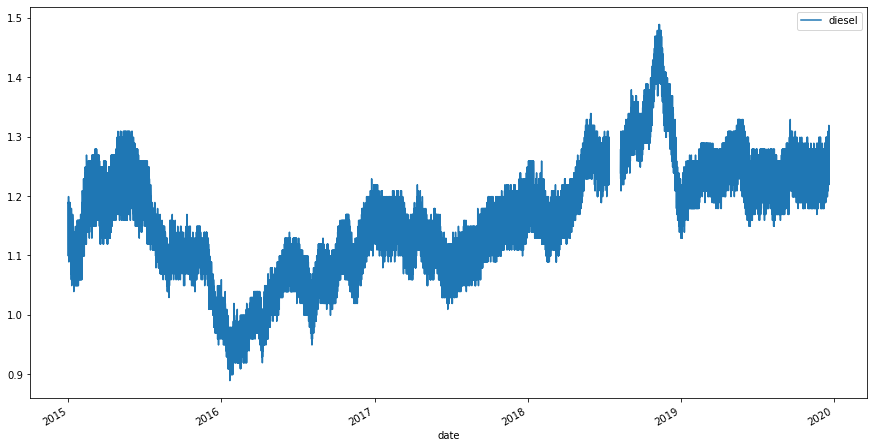

In [39]:
#let's have a look at the data
star_bahn.plot(figsize=(15,8));

### Resample the data
In the above cells you could see, that the timestamps vary, that means the stations transmit new prices directly after changing them. I'll want to forecast on a daily basis, therefore i'll resample the data to days and take the mean. Also i will use a ffill to overcome missing values.

In [40]:
# get samples per day
star_day = star_bahn.resample('d').mean().ffill()

In [41]:
star_day.shape

(1815, 1)

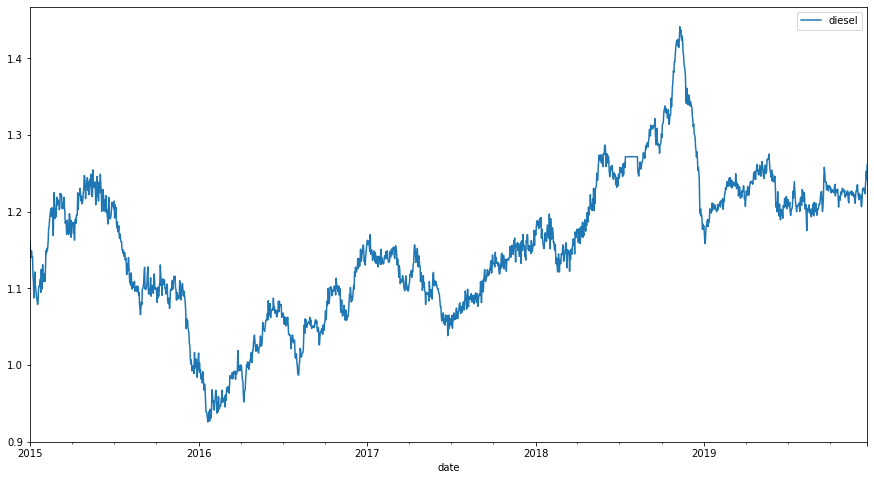

In [42]:
star_day.plot(figsize=(15,8));

In [43]:
star_day.isna().sum()

diesel    0
dtype: int64

So we have no np.nan anymore in our dataset, but we have a few day in 2018 without data. Possible the station was closed in this time. I'll think this should not be a problem.

In [44]:
# get another station
total = get_data4uid(prices_pd, '79fb1f24-bebb-489e-841f-728f9053b555', 'diesel')

In [45]:
total_day = total.resample('d').mean().ffill()

In [46]:
total_day.diesel.idxmax()

Timestamp('2018-11-09 00:00:00+0000', tz='UTC', freq='D')

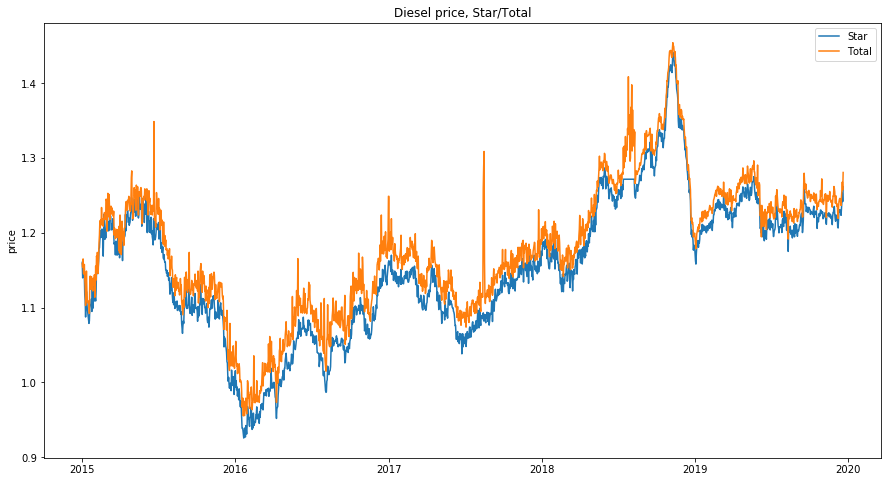

In [47]:
# plot both stations in one plot to see 
plt.figure(figsize=(15,8));
plt.plot(star_day, label = 'Star');
plt.plot(total_day, label = 'Total');
plt.title('Diesel price, Star/Total')
plt.ylabel('price')
plt.legend();

### Wrong data?
The price of Total diesel price somewhre between july/august of 2017 is one crazy peak. Let's have a closer look...

In [48]:
total_day['2017-07':'2017-08'].diesel.idxmax()

Timestamp('2017-08-16 00:00:00+0000', tz='UTC', freq='D')

In [49]:
total_day['2017-08-12':'2017-08-18'].diesel

date
2017-08-12 00:00:00+00:00    1.114000
2017-08-13 00:00:00+00:00    1.114556
2017-08-14 00:00:00+00:00    1.259000
2017-08-15 00:00:00+00:00    1.289000
2017-08-16 00:00:00+00:00    1.309000
2017-08-17 00:00:00+00:00    1.161500
2017-08-18 00:00:00+00:00    1.115667
Freq: D, Name: diesel, dtype: float64

In [50]:
total['2017-08-13':'2017-08-17'].diesel

date
2017-08-13 06:27:05+00:00    1.189
2017-08-13 07:17:05+00:00    1.089
2017-08-13 08:57:06+00:00    1.089
2017-08-13 09:47:07+00:00    1.069
2017-08-13 10:27:05+00:00    1.099
2017-08-13 15:12:06+00:00    1.119
2017-08-13 16:27:05+00:00    1.089
2017-08-13 18:27:06+00:00    1.069
2017-08-13 19:57:06+00:00    1.219
2017-08-14 10:28:06+00:00    1.249
2017-08-14 15:12:07+00:00    1.269
2017-08-15 15:12:06+00:00    1.289
2017-08-16 15:12:06+00:00    1.309
2017-08-17 07:17:05+00:00    1.109
2017-08-17 10:27:06+00:00    1.139
2017-08-17 15:12:09+00:00    1.159
2017-08-17 19:57:07+00:00    1.239
Name: diesel, dtype: float64

The data seems to be valid, it could be that some dataset is missing and therefore the step is so big. On 14th there are only two values and on 15+16th of august there is only one value. It is a little bit strange, but it can be. So i will left this data as is.

In [51]:
# want to see the differences from day to day
star_day_diff = star_day.diff()
total_day_diff = total_day.diff()

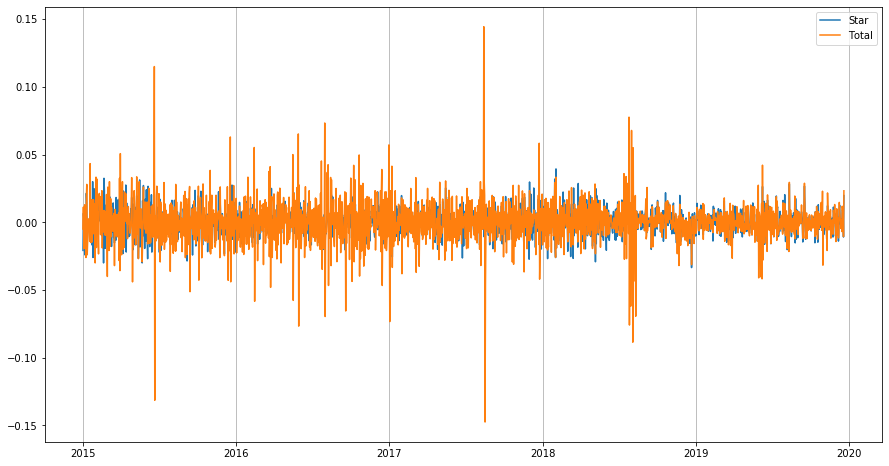

In [52]:
plt.figure(figsize=(15,8))
plt.plot(star_day_diff)
plt.plot(total_day_diff)
plt.grid(axis='x')
plt.legend(['Star', 'Total']);

#### Many differences...
between days, but now let's have a closer look in a shorter time frame and the corresponding prices.
The two choosen stations are located nearby each other, around 500 m distance.

In [53]:
star_intraday = star_bahn['2017-05-01':'2017-05-07']

In [54]:
total_intraday = total['2017-05-01':'2017-05-07']

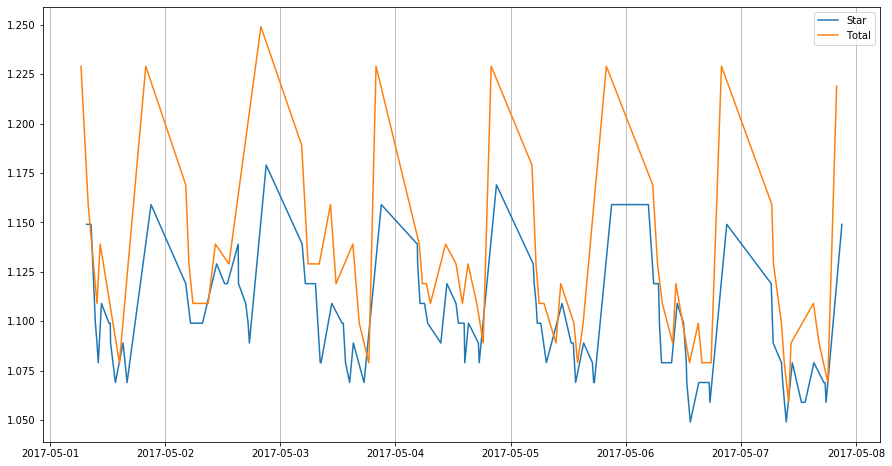

In [55]:
plt.figure(figsize=(15,8))
plt.plot(star_intraday)
plt.plot(total_intraday)
plt.grid(axis='x')
plt.legend(['Star', 'Total']);

#### Findings
In the plot above you can easily find who follows whom: The Total is raising the price first and Star is following. In price reduction Star is first and Total follows. Interesting :-)

#### Daily highs and lows
How does it look during a day? When is the lowest price on a day, when is the highest in the mean over all days? 
Therefore I make a function to plot the data.

In [56]:
def plot_day4uuid(uuid, typ='diesel', name=None, save=None):
    '''
    plots a distribution of prices on a day based on last year and for 2019
    Input: 
    uuid : id of station
    typ : which type of gas 
    name : Title for the plot
    save : filename to save'''
    hourly_ticks = 60 * 60 * np.arange(24)
    data = get_data4uid(prices_pd, uuid, typ)
    # drop wrong data
    data.drop(data[data[typ] < 0.5].index, inplace=True)
    data.dropna(inplace=True)
    
    # resample to hourly values
    data_h = data.resample('H').mean().dropna()
    # groupby hour for all data 
    data_byday = data_h.groupby(data_h.index.time).mean()
    # groupby hour only for 2019
    data_2019 = data_h['2019-01-01':]
    data_byday_2019 = data_2019.groupby(data_2019.index.time).mean()
    # bug in pandas plot
    # workaround found in https://github.com/facebook/prophet/issues/999
    pd.plotting.register_matplotlib_converters()
    
    plt.figure(figsize=(15,8))
    plt.plot(data_byday, label='Hourly Mean')
    plt.plot(data_byday_2019, label='Hourly Mean 2019')
    if name:
        plt.title(name)
    else:
        plt.title(uuid)
    plt.legend()
    plt.xticks(hourly_ticks)
    if save:
        plt.savefig(save)


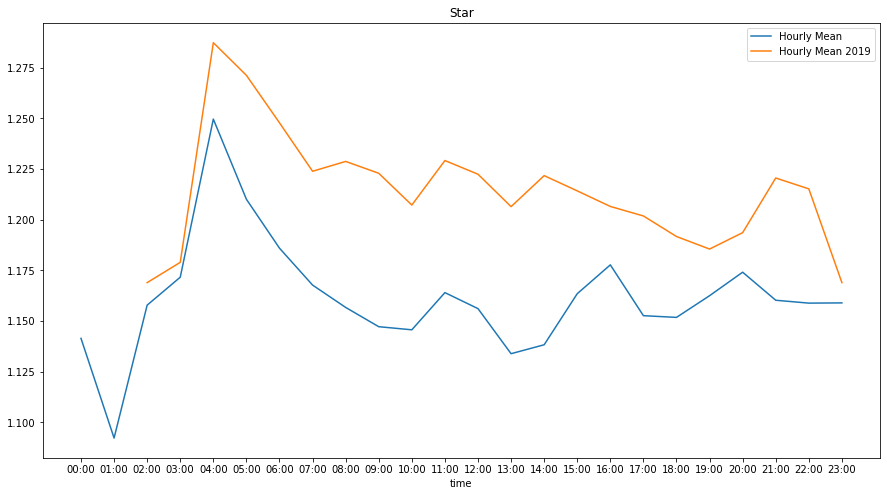

In [57]:
plot_day4uuid('005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel', 'Star') #, save='./star_hourly_mean.png')

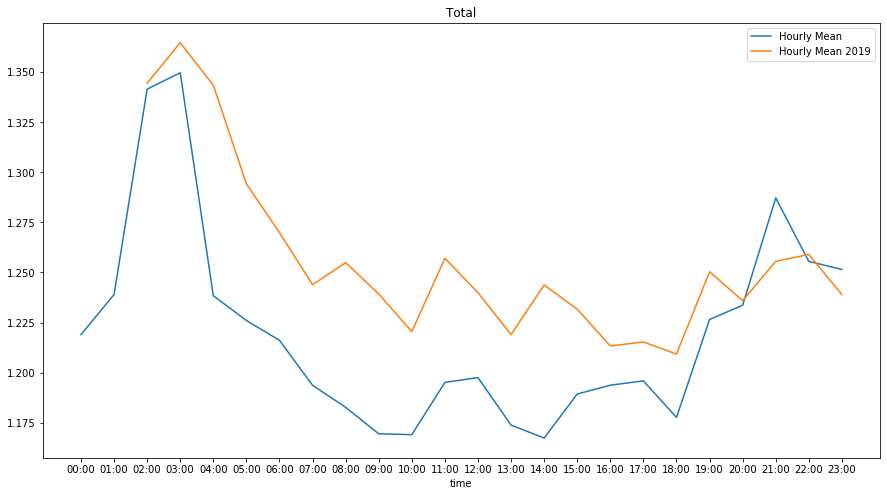

In [58]:
plot_day4uuid('79fb1f24-bebb-489e-841f-728f9053b555', 'diesel', 'Total')

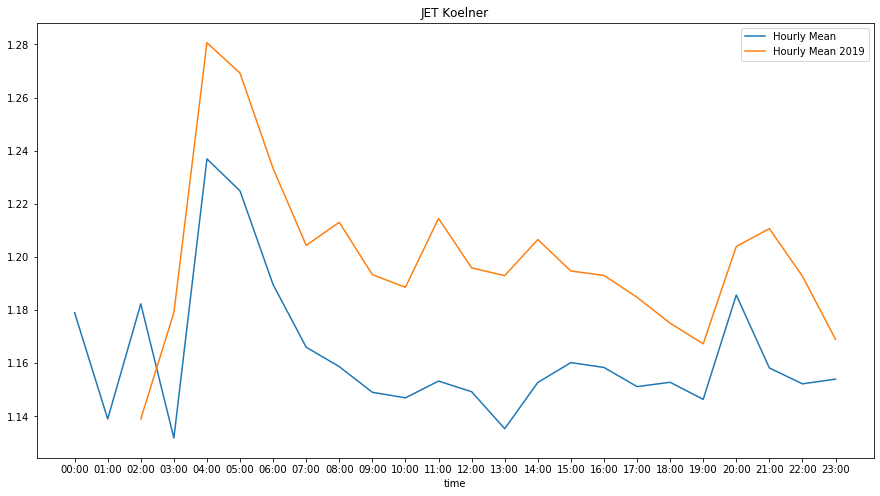

In [59]:
plot_day4uuid('51d4b59c-a095-1aa0-e100-80009459e03a', name='JET Koelner') #, save='./jetkoelner.png')

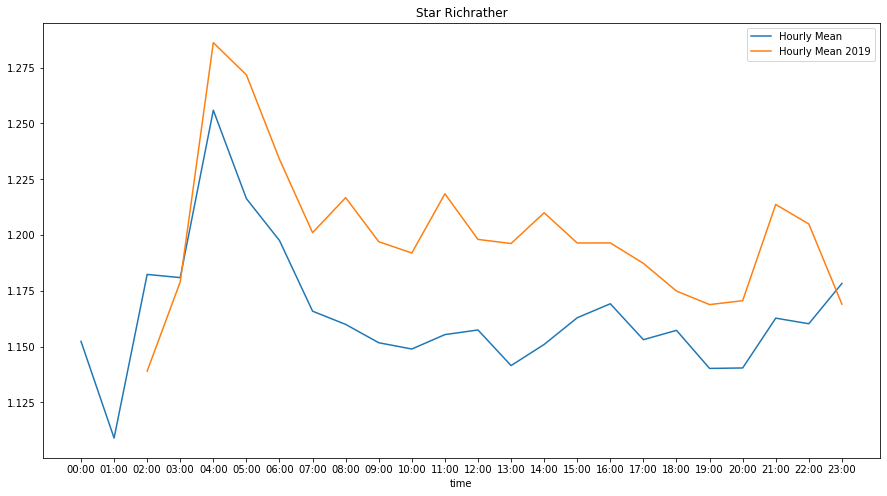

In [60]:
plot_day4uuid('005056ba-7cb6-1ed2-bceb-a46e32000d3e', name='Star Richrather') #, save='./starrichrather.png')

In [61]:
star_bahn.describe()

diesel
count  22218.000000
mean       1.171140
std        0.093704
min        0.889000
25%        1.109000
50%        1.179000
75%        1.229000
max        1.489000

#### Good Time, good price
It seems in the examples above that in average it is a good to get fuel in the evening, depending on your preferred station beween 18-19 o'clock (Star) or 16-19 o'clock (Total). The standard deviation is 9 cent, so it can be money saving to get fuel at the right time.

#### Price depending on weekday?
To answer this question i grouped the data by hour and weekday.

In [62]:
def plot_weekday4uuid(uuid, typ='diesel', name=None, save=None):
    '''
    plots a distribution of prices for weekday based on last years and for 2019
    Input: 
    uuid : id of station
    typ : which type of gas 
    name : Title for the plot
    save : filename to save'''
    hourly_ticks = np.arange(25)
    data = get_data4uid(prices_pd, uuid, typ)
    # drop wrong data
    data.dropna(inplace=True)
    
    # resample to hourly values
    data = data.resample('H').mean().dropna()
    
    # groupby hour only for 2019
    data_2019 = data['2019-01-01':].copy()
    
    data['day'] = data.index.weekday
    data['hour'] = data.index.hour
    data_2019['day'] = data_2019.index.weekday
    data_2019['hour'] = data_2019.index.hour

    
    fig, [ax, ax2] = plt.subplots(2, 1, figsize=(15,12), constrained_layout=True)
    
    data.groupby(['hour','day']).mean()['diesel'].unstack().plot(ax=ax)
    data_2019.groupby(['hour','day']).mean()['diesel'].unstack().plot(ax=ax2)

    if name:
        ax.set_title(name)
        ax2.set_title(name+' 2019')
    else:
        ax.set_title(uuid)
        ax.set_title(uuid+' 2019')

    #ax.legend()
    ax.set_xticks(hourly_ticks)
    ax2.set_xticks(hourly_ticks)
    #ax.set_xlim(6,23)
    #ax2.set_xlim(6,23)
    fig.suptitle('Hourly prices grouped on weekdays', fontsize=16)
    if save:
        fig.savefig(save)

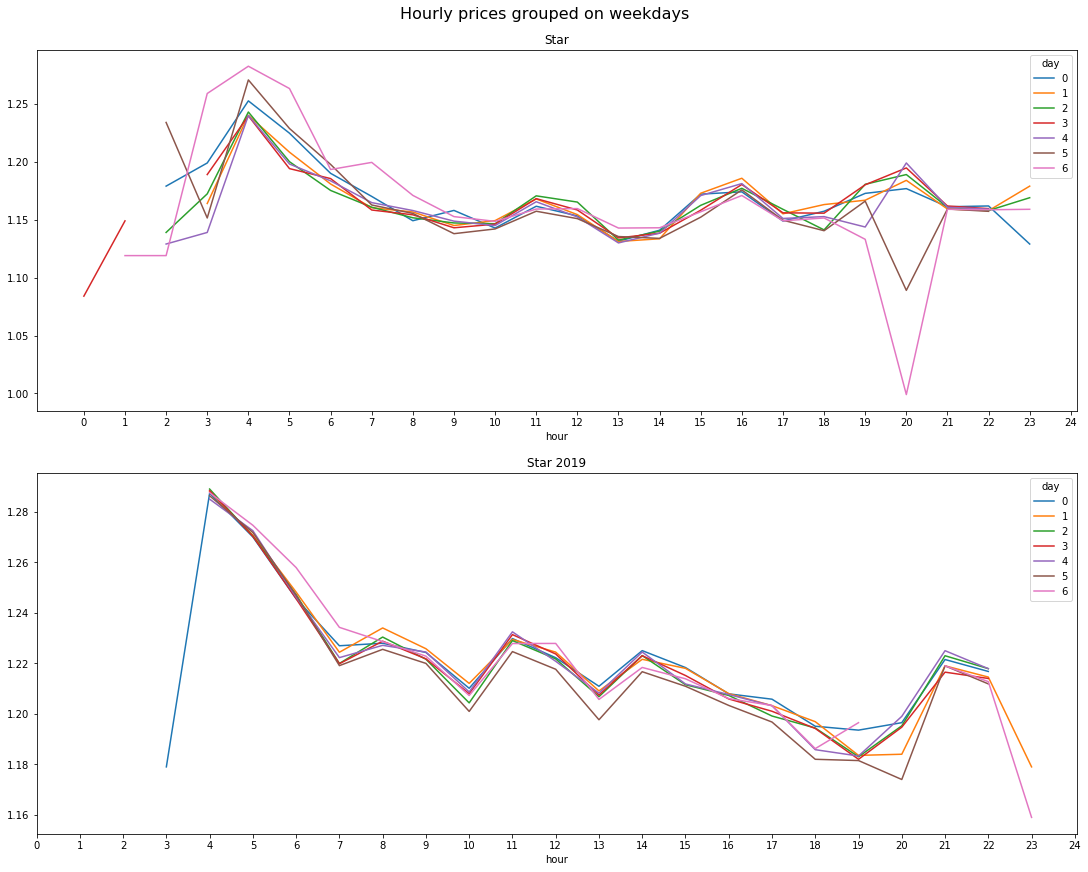

In [63]:
plot_weekday4uuid('005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel', 'Star') #, './hourly_based_weekdays.png')

Here we have a big difference in the years before 2019, there was Saturday and Sunday at 8 pm a obvious lowest price. In 2019 this is not more noticeable on Sundays but on Saturday it seems to be still the best time for cheapest prices.

### Statistics

Now let's see some statistics from all stations in this area and make a nice plot of it with plotly.

In [64]:
prices_pd

date                          station_uuid  \
2566   2015-01-01 04:06:01+00:00  e43c09b0-5baa-4738-962a-c94388e93c30   
2856   2015-01-01 04:10:01+00:00  e43c09b0-5baa-4738-962a-c94388e93c30   
4220   2015-01-01 04:26:01+00:00  e7807347-796f-4aac-997d-07d0c988e109   
11890  2015-01-01 08:50:01+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
12420  2015-01-01 09:02:01+00:00  5bf85d09-ea6b-4146-b23f-4b902e2e1554   
...                          ...                                   ...   
242167 2019-12-20 21:05:04+00:00  e7807347-796f-4aac-997d-07d0c988e109   
244397 2019-12-20 21:52:04+00:00  51d4b59c-a095-1aa0-e100-80009459e03a   
245985 2019-12-20 22:03:03+00:00  005056ba-7cb6-1ed2-bceb-82ea369c0d2d   
246263 2019-12-20 22:05:04+00:00  005056ba-7cb6-1ed2-bceb-a46e32000d3e   
247406 2019-12-20 22:17:04+00:00  5bf85d09-ea6b-4146-b23f-4b902e2e1554   

        diesel     e5    e10  
2566     1.239  1.379  1.339  
2856     1.199  1.359  1.319  
4220     1.199  1.349  1.309  
11890    1.189  1.339  1.299  
12420    1.189  1.339  1.299  
...        ...    ...    ...  
242167   1.319  1.449  1.409  
244397   1.229  1.369  1.349  
245985   1.259  1.379  1.359  
246263   1.229  1.369  1.349  
247406   1.259  1.379  1.359  

[168058 rows x 5 columns]

In [65]:
prices_pd.diesel.dropna(inplace=True)

In [66]:
# group on station_uuid and have a look at "diesel"
grouped = prices_pd.groupby('station_uuid')[['diesel']]

In [67]:
grouped.describe()

diesel                             
                                      count mean std min 25% 50% 75% max
station_uuid                                                            
00041414-208c-4444-8888-acdc00000414    0.0  NaN NaN NaN NaN NaN NaN NaN
005056ba-7cb6-1ed2-bceb-7e82e4910d2a    0.0  NaN NaN NaN NaN NaN NaN NaN
005056ba-7cb6-1ed2-bceb-7ef561844d2a    0.0  NaN NaN NaN NaN NaN NaN NaN
005056ba-7cb6-1ed2-bceb-7f34524ccd2a    0.0  NaN NaN NaN NaN NaN NaN NaN
005056ba-7cb6-1ed2-bceb-80c585ca6d2b    0.0  NaN NaN NaN NaN NaN NaN NaN
...                                     ...  ...  ..  ..  ..  ..  ..  ..
fbcdf8a7-b6ba-4ec3-ac4c-dde2f0f29934    0.0  NaN NaN NaN NaN NaN NaN NaN
fcdaddc5-7dc1-49f9-8286-71e8664f9e17    0.0  NaN NaN NaN NaN NaN NaN NaN
fd99c048-3b6b-4943-8b93-838daefba76b    0.0  NaN NaN NaN NaN NaN NaN NaN
fdc30c82-9cdf-4fd9-a000-bc2bfe0fc7bf    0.0  NaN NaN NaN NaN NaN NaN NaN
ff55d404-3609-48b2-b16a-ef4a9f2008a0    0.0  NaN NaN NaN NaN NaN NaN NaN

[132 rows x 8 columns]

In [68]:
# calculate some statistical values
var_price = grouped.var()
min_price = grouped.min()
std_price = grouped.std()
var_price.rename(inplace=True, columns={"diesel":"var"})
min_price.rename(inplace=True, columns={"diesel":"min"})
std_price.rename(inplace=True, columns={"diesel":"std"})


In [69]:
short_pd = stations_pd.copy()
short_pd.set_index(['uuid'], inplace=True)

In [70]:

short_pd = short_pd.join(var_price)
short_pd = short_pd.join(min_price)
short_pd = short_pd.join(std_price)

In [71]:
short_pd.dropna(inplace=True, subset=['var', 'min', 'std'])

In [72]:
short_pd.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, e43c09b0-5baa-4738-962a-c94388e93c30 to 82119d5d-775f-42af-ac56-000d7c91413f
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               8 non-null      object 
 1   brand              7 non-null      object 
 2   street             8 non-null      object 
 3   house_number       6 non-null      object 
 4   post_code          8 non-null      object 
 5   city               8 non-null      object 
 6   latitude           8 non-null      float64
 7   longitude          8 non-null      float64
 8   first_active       8 non-null      object 
 9   openingtimes_json  8 non-null      object 
 10  var                8 non-null      float64
 11  min                8 non-null      float64
 12  std                8 non-null      float64
dtypes: float64(5), object(8)
memory usage: 896.0+ bytes


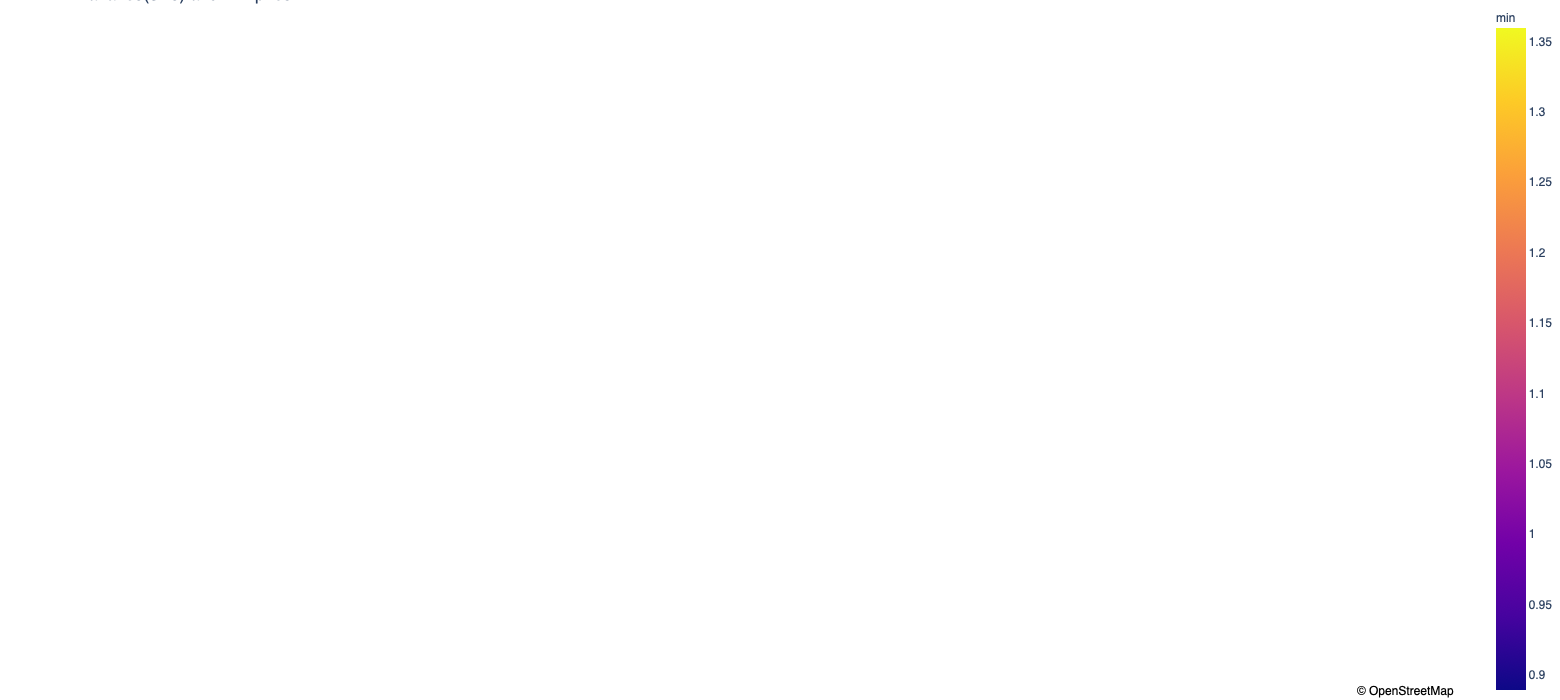

In [73]:
fig = px.scatter_mapbox(short_pd, lat="latitude", lon="longitude", hover_name="name", hover_data=["city", "post_code"],
                        color_discrete_sequence=["fuchsia"], zoom=10, width=700, height=700, size="var", color="min", title="Variance(size) and Min price")
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [2]:
# Load data if you start here
prices_pd, stations_pd = load_data('./Data/prices_40.sql')

### Forecast model

All libraries and data was loaded before, here i want to build a forecast model for fuel prices.
First I'll we have a closer look to the data with the statsmodel package. 


In [3]:
star_bahn = get_data4uid(prices_pd, '005056ba-7cb6-1ed2-bceb-82ea369c0d2d', 'diesel')

In [4]:
star_bahn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22543 entries, 2015-01-01 08:50:01+00:00 to 2019-12-20 22:03:03+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   diesel  22218 non-null  float64
dtypes: float64(1)
memory usage: 352.2 KB


In [5]:
# i want to use daily values for the ongoing analysis
# use ffill to have a value for each day, otherwise ARIMA model has problems

star_bahn.dropna(inplace=True)
star_day = star_bahn.resample('d').mean().ffill()


In [6]:
star_day = star_day.asfreq('d')
star_day.dropna(inplace=True)

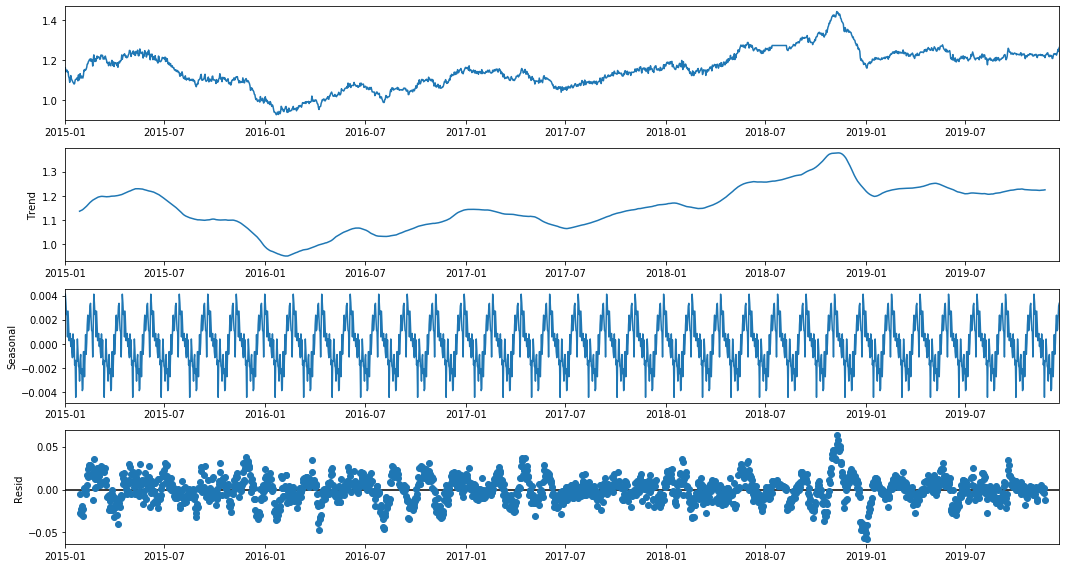

In [72]:
# let's see what is in the data, let assume a weekly seasonal
decompostion = sm.tsa.seasonal_decompose(star_day, period=52, model='additive')
decompostion.plot();

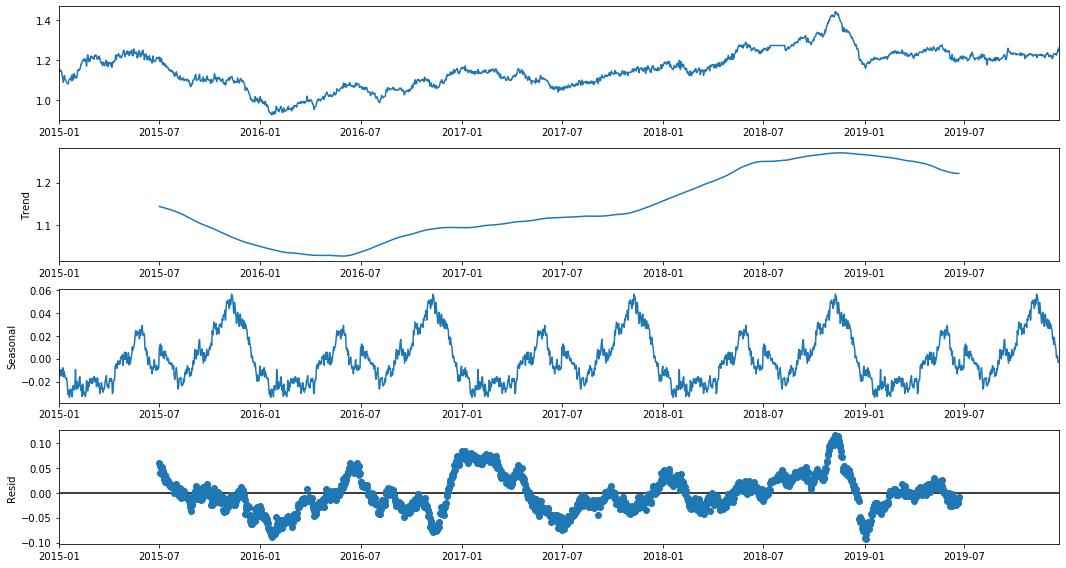

In [73]:
# now let's see if we a yearly seasonal aspect inside
decompostion = sm.tsa.seasonal_decompose(star_day, period=365, model='additive')
decompostion.plot();

### Trend and Saisonality

In the above plots you can easily see, there is a trend and a seasonal aspect in the data. In the first plot you'll see the weekly seasonal aspects and in the second plot you can also see a yearly seasonal aspect in the diesel price.
Therefore a standard ARIMA model will have problems with such data, even the SARIMA model, because the data is not stationary.

The stationarity can be forced with the difference, let's see...

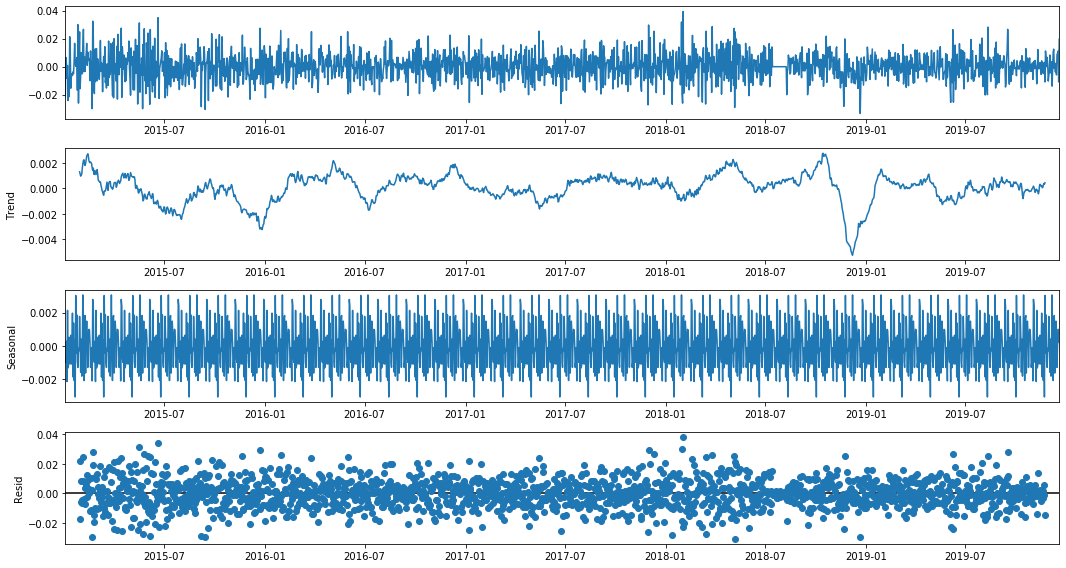

In [74]:
decompostion = sm.tsa.seasonal_decompose(star_day.diff().dropna(), period=52, model='additive')
decompostion.plot();

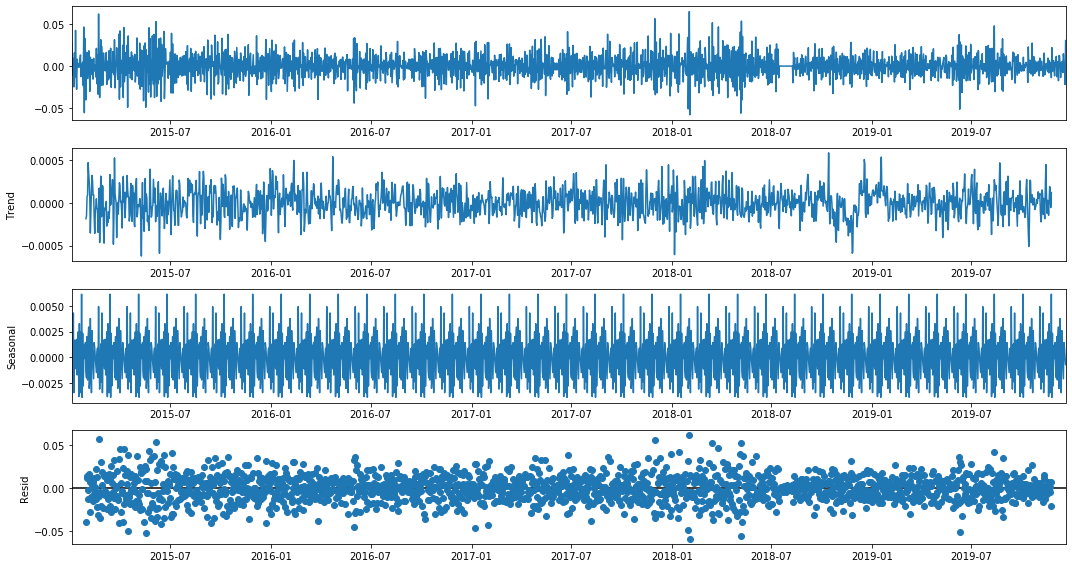

In [75]:
decompostion = sm.tsa.seasonal_decompose(star_day.diff().dropna().diff().dropna(), period=52, model='additive')
decompostion.plot();

Even in the first difference there is a small trend, it is removed when we diff a second time.

#### ACF/PACF
Let's see if it is also seen in ACF and PACF.

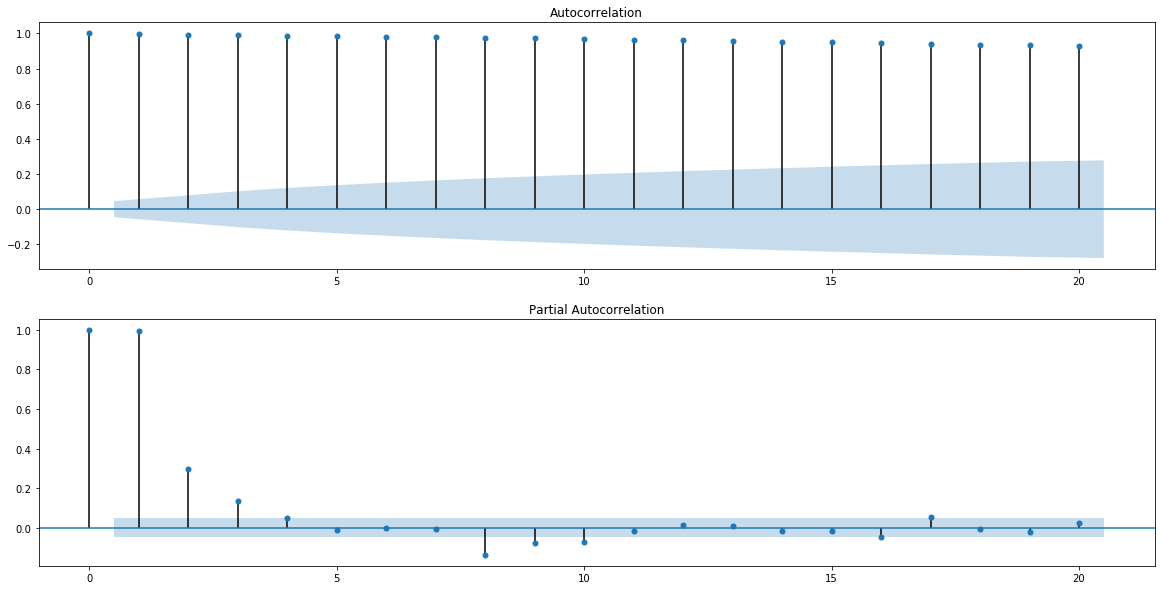

In [76]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.dropna(), lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.dropna(), lags=20, ax=ax[1])
plt.show()

So from the ACF there is also clearly, that the raw data is not stationary. Let's see hte ACF and PACF for the first difference.

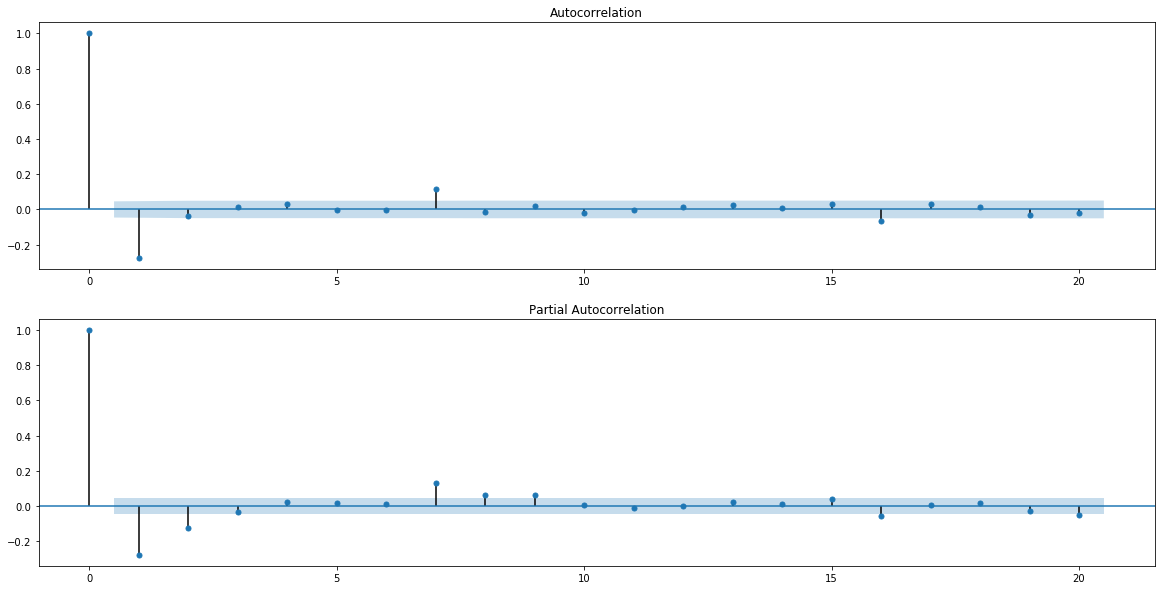

In [77]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(star_day.diff().dropna(), lags=20, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(star_day.diff().dropna(), lags=20, ax=ax[1])
plt.show()

The original data is not stationary, seen in the Autocorrelation part. But the first difference seems to be good (means stationary). Let's see what the ADF and KPSS test will tell us about the raw data and the first difference.

In [78]:
# found this summary for all values of Adfuller and KPSS test usefull and therefore copy and pasted it here
def stationarity_test(ts):
    print('Results of ADF Test:')
    df = sm.tsa.adfuller(ts, autolag='AIC')
    df_out = pd.Series(df[0:3], index = ['Test Statistic', 'p-value', 'Number of lags'])
    for key,value in df[4].items():
        df_out['Critical Value (%s)'%key] = value
    print(df_out)
    
#When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).


In [79]:
stationarity_test(star_day.diesel.dropna())

Results of ADF Test:
Test Statistic         -1.759272
p-value                 0.400861
Number of lags          9.000000
Critical Value (1%)    -3.433978
Critical Value (5%)    -2.863143
Critical Value (10%)   -2.567623
dtype: float64


In [80]:
stationarity_test(star_day.diesel.diff().dropna())

Results of ADF Test:
Test Statistic         -1.181777e+01
p-value                 8.556667e-22
Number of lags          8.000000e+00
Critical Value (1%)    -3.433978e+00
Critical Value (5%)    -2.863143e+00
Critical Value (10%)   -2.567623e+00
dtype: float64


The Adfuller test for the first difference is also ok, the p-value is nearly zero, means the first difference is stationary. So we can use d=1 for the ARIMA model.
### ARIMA model

The ACF gives a hint for the q value (MA) and the PACF gives a hint for the p value (AR) for the ARIMA model. In the ACF/PACF plot from first difference you can see in ACF lag 1, (2) and 7 outside the benchmark and for the PACF lag 1, 2, (3), 7, 8, 9 outside the benchmark. As a rule of thumb you should start with the least amount of lags outside the benchmark. So i'll start with q of 1.

First i've to prepare the dataset index, it is a datetime index with localization. I will remove the localization and convert the index to a Datetime Index with period 'D'.

In [7]:
star_day.index

DatetimeIndex(['2015-01-01 00:00:00+00:00', '2015-01-02 00:00:00+00:00',
               '2015-01-03 00:00:00+00:00', '2015-01-04 00:00:00+00:00',
               '2015-01-05 00:00:00+00:00', '2015-01-06 00:00:00+00:00',
               '2015-01-07 00:00:00+00:00', '2015-01-08 00:00:00+00:00',
               '2015-01-09 00:00:00+00:00', '2015-01-10 00:00:00+00:00',
               ...
               '2019-12-11 00:00:00+00:00', '2019-12-12 00:00:00+00:00',
               '2019-12-13 00:00:00+00:00', '2019-12-14 00:00:00+00:00',
               '2019-12-15 00:00:00+00:00', '2019-12-16 00:00:00+00:00',
               '2019-12-17 00:00:00+00:00', '2019-12-18 00:00:00+00:00',
               '2019-12-19 00:00:00+00:00', '2019-12-20 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='date', length=1815, freq='D')

In [8]:
star_day = star_day.tz_localize(None)

In [9]:
star_day.index = pd.DatetimeIndex(star_day.index).to_period('D')

In [10]:
star_day.index

PeriodIndex(['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-04',
             '2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
             '2015-01-09', '2015-01-10',
             ...
             '2019-12-11', '2019-12-12', '2019-12-13', '2019-12-14',
             '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
             '2019-12-19', '2019-12-20'],
            dtype='period[D]', name='date', length=1815, freq='D')

**Then I split the data in train and test. For train i'll use the data from 2015-2018 and for test i'll use 2019.**

In [11]:
# split train and test data
train = star_day['2015-01-01':'2018-12-31'].diesel
test = star_day['2019-01-01':].diesel

train.size, test.size

(1461, 354)

**Let's see what the arma_order_select_ic gives as best parameter for (p, q).**

In [86]:
order_sel = sm.tsa.arma_order_select_ic(train, max_ar = 4, max_ma = 4, ic=['aic', 'bic'], trend='c')
print('ARIMA: ', order_sel['aic_min_order'], order_sel['bic_min_order'])

/Users/joerg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/joerg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/joerg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/joerg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


ARIMA:  (3, 2) (3, 2)


#### Define some helper functions for fitting and forecasting different models. Also a function to print the kpi's and plot the prediction.

In [12]:
def fit_arima(order, season_order):
    '''Fit Arima model and give back result and predictions'''
    print(order, season_order)
    result = sm.tsa.statespace.SARIMAX(endog=train, order=order, seasonal_order=season_order, enforce_invertibility=False, enforce_stationarity=False).fit()
    print(result.summary())
    pred = result.forecast(steps=354)
    return result, pred
    
def kpi_plot(pred):
    '''Prints the MSE and R2 Score and plots the prediction vs original'''
    
    print('ARIMA model MSE:{}'.format(mean_squared_error(test,pred)))
    print('R2 Score: {}'.format(r2_score(test,pred)))
    
    pred.plot(label='predicted')
    test.plot(label='test')
    plt.fill_between(pred.index,
                     pred,
                     test, color='k', alpha=.2)

    plt.legend()

As described above i'll start only with q=1 as first approach.

In [24]:
result, pred = fit_arima((0,1,1), (0,1,1,52))

(0, 1, 1) (0, 1, 1, 52)
                                     SARIMAX Results                                      
Dep. Variable:                             diesel   No. Observations:                 1461
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood                4320.290
Date:                            Tue, 21 Jul 2020   AIC                          -8634.580
Time:                                    09:46:56   BIC                          -8618.948
Sample:                                01-01-2015   HQIC                         -8628.727
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3248      0.024    -13.611      0.000      -0.372      -0.278
ma.S.L52   

ARIMA model MSE:0.001827971789383413
R2 Score: -3.891623163418407


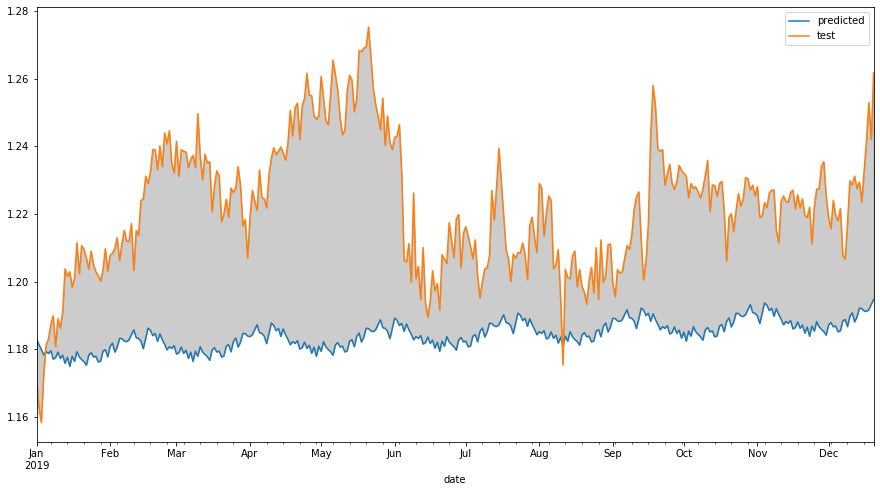

In [25]:
kpi_plot(pred)

In [26]:
result, pred = fit_arima((3,1,1), (3,1,1,52))

(3, 1, 1) (3, 1, 1, 52)


/Users/joerg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                             diesel   No. Observations:                 1461
Model:             SARIMAX(3, 1, 1)x(3, 1, 1, 52)   Log Likelihood                3994.987
Date:                            Tue, 21 Jul 2020   AIC                          -7971.974
Time:                                    11:27:23   BIC                          -7925.803
Sample:                                01-01-2015   HQIC                         -7954.616
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1074      0.632     -0.170      0.865      -1.347       1.132
ar.L2          0.0242      0.165   

ARIMA model MSE:0.0008163613721628683
R2 Score: -1.1845699266173568


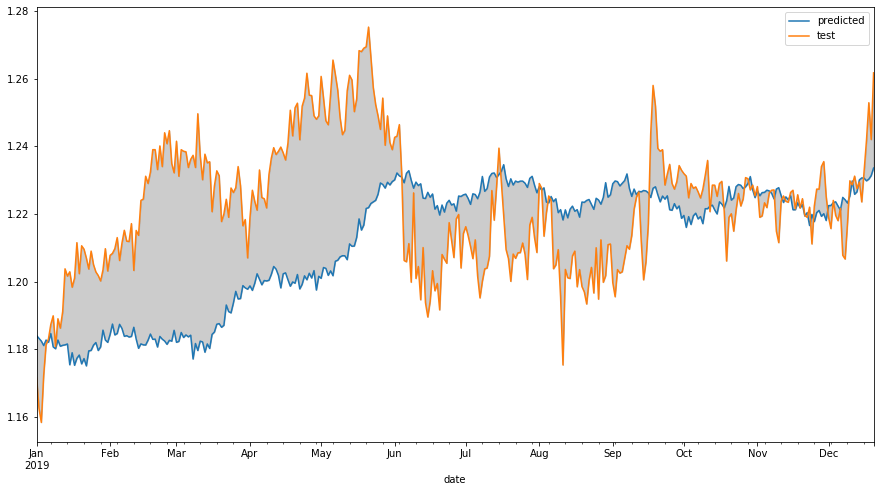

In [27]:
kpi_plot(pred)

In [13]:
result, pred = fit_arima((3,1,2), (3,1,2,52))

(3, 1, 2) (3, 1, 2, 52)


/Users/joerg/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                             diesel   No. Observations:                 1461
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 52)   Log Likelihood                3993.675
Date:                            Tue, 21 Jul 2020   AIC                          -7965.350
Time:                                    21:44:00   BIC                          -7908.919
Sample:                                01-01-2015   HQIC                         -7944.135
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6698      0.256     -2.612      0.009      -1.172      -0.167
ar.L2         -0.3050      0.133   

ARIMA model MSE:0.0009820897193220269
R2 Score: -1.6280563231291079


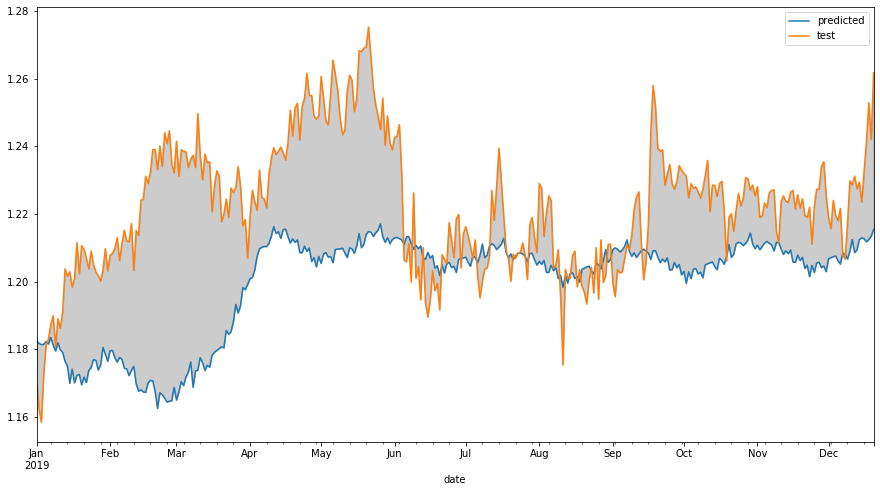

In [14]:
kpi_plot(pred)

### Not Bad but also not good
The ARIMA (3,1,2) or (3,1,1) has the best prediction for the test data set. Also it has big differences in some months. In this calculation, the (3,1,1) was slightly better.

### LSTM

I will now try to build a LSTM model for prediction. Therefore i will scale the input and divide in three sets: train, validation and test data.

In [15]:
# the values have to be normalized for LSTM
values = star_day['diesel'].values.reshape(-1,1)
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [16]:
# use the same data for training up to 2018
train_size = len(star_day[:'2018-12-31'])
vali_size = 31 # let's take 1 month as validation set for fitting
test_size = len(scaled) - train_size - vali_size
train, vali, test = scaled[:train_size,:], scaled[train_size:train_size+vali_size,:], scaled[train_size+vali_size:, :]
print(len(train), len(vali), len(test))

1461 31 323


In [17]:
def create_data(dataset, look_back=1):
    '''creates two array of x and y out of the given array
    Input: Array of data, steps to look back
    Output: X, Y
    '''
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i+look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)



In [18]:
look_back = 2
trainX, trainY = create_data(train, look_back)
valiX, valiY = create_data(vali, look_back)
testX, testY = create_data(test, look_back)

1459
29
321


In [19]:
# reshape to make it usable as input for LSTM
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
valiX = np.reshape(valiX, (valiX.shape[0], 1, valiX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
# build a LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(valiX, valiY), verbose=0, shuffle=False)

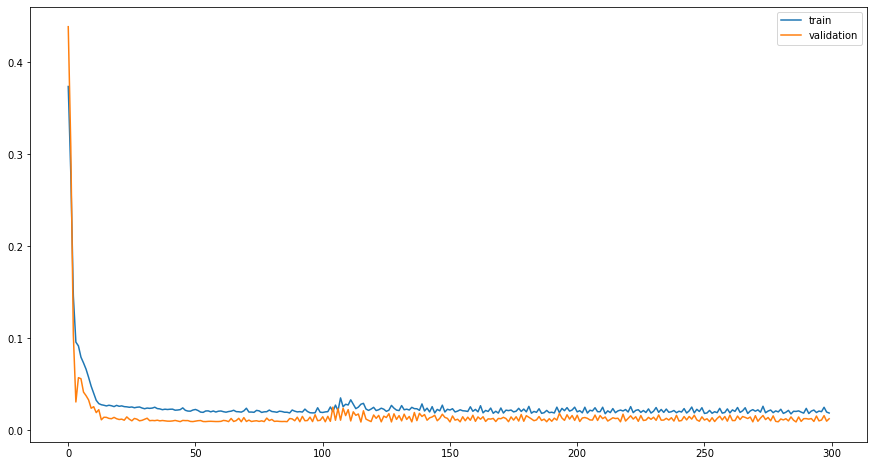

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend();

In [22]:
history.params

{'batch_size': 100,
 'epochs': 300,
 'steps': None,
 'samples': 1459,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'val_loss']}

In [23]:
# make predictions
train_pre = model.predict(trainX)
vali_pre = model.predict(valiX)
test_pre = model.predict(testX)
# invert predictions
train_pre = scaler.inverse_transform(train_pre)
trainY = scaler.inverse_transform([trainY])
vali_pre = scaler.inverse_transform(vali_pre)
valiY = scaler.inverse_transform([valiY])
test_pre = scaler.inverse_transform(test_pre)
testY = scaler.inverse_transform([testY])

# calculate mean squared error and R2 score
trainScore = mean_squared_error(trainY[0], train_pre[:,0])
print('Train Score MSE {}'.format(trainScore))
valiScore = mean_squared_error(valiY[0], vali_pre[:,0])
print('Validation Score MSE {}'.format(trainScore))
testScore = mean_squared_error(testY[0], test_pre[:,0])
print('Test Score MSE {}'.format(testScore))
print('Train R2 Score: {}'.format(r2_score(trainY[0],train_pre[:,0])))
print('Validation R2 Score: {}'.format(r2_score(valiY[0],vali_pre[:,0])))
print('Test R2 Score: {}'.format(r2_score(testY[0],test_pre[:,0])))


Train Score MSE 0.00016088020518132206
Validation Score MSE 0.00016088020518132206
Test Score MSE 9.643163496997665e-05
Train R2 Score: 0.9827632311561171
Validation R2 Score: 0.6314248998941643
Test R2 Score: 0.6897590564535172


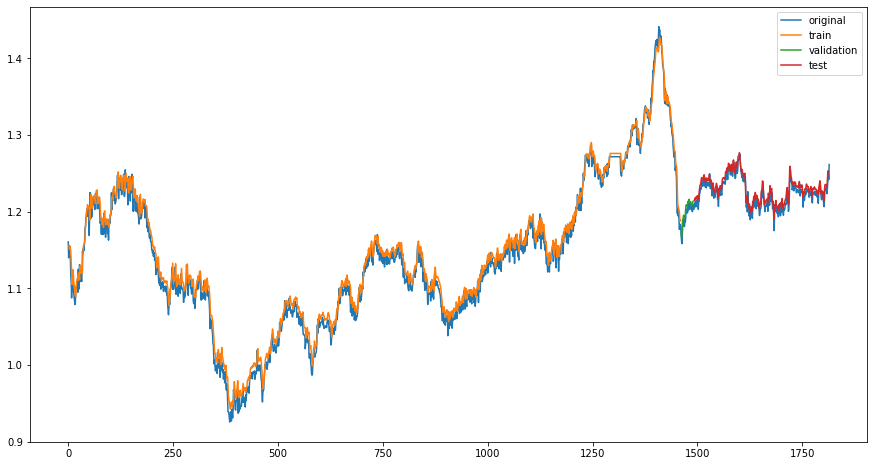

In [24]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_pre)+look_back, :] = train_pre
#shift test predictions for plotting
valiPredictPlot = np.empty_like(scaled)
valiPredictPlot[:, :] = np.nan
valiPredictPlot[len(train_pre)+(look_back*2)-2:len(train_pre)+vali_size, :] = vali_pre

# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_pre)+vali_size+(look_back*2)-2:len(scaled)-2, :] = test_pre
# plot baseline and predictions
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(valiPredictPlot)
plt.plot(testPredictPlot)
plt.legend(['original', 'train', 'validation', 'test'])
plt.show()

In [25]:
# make a dataframe of the predictions and set index, the test data starts val_size + lookback in our case the 3rd february 2019
test_pre_pd = pd.DataFrame(test_pre)
test_pre_pd.index = star_day['2019-02-03':'2019-12-20'].index


In [26]:
star_day['2019-02-03':'2019-12-20'].index

PeriodIndex(['2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06',
             '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10',
             '2019-02-11', '2019-02-12',
             ...
             '2019-12-11', '2019-12-12', '2019-12-13', '2019-12-14',
             '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
             '2019-12-19', '2019-12-20'],
            dtype='period[D]', name='date', length=321, freq='D')

In [27]:
test_pre_pd.index

PeriodIndex(['2019-02-03', '2019-02-04', '2019-02-05', '2019-02-06',
             '2019-02-07', '2019-02-08', '2019-02-09', '2019-02-10',
             '2019-02-11', '2019-02-12',
             ...
             '2019-12-11', '2019-12-12', '2019-12-13', '2019-12-14',
             '2019-12-15', '2019-12-16', '2019-12-17', '2019-12-18',
             '2019-12-19', '2019-12-20'],
            dtype='period[D]', name='date', length=321, freq='D')

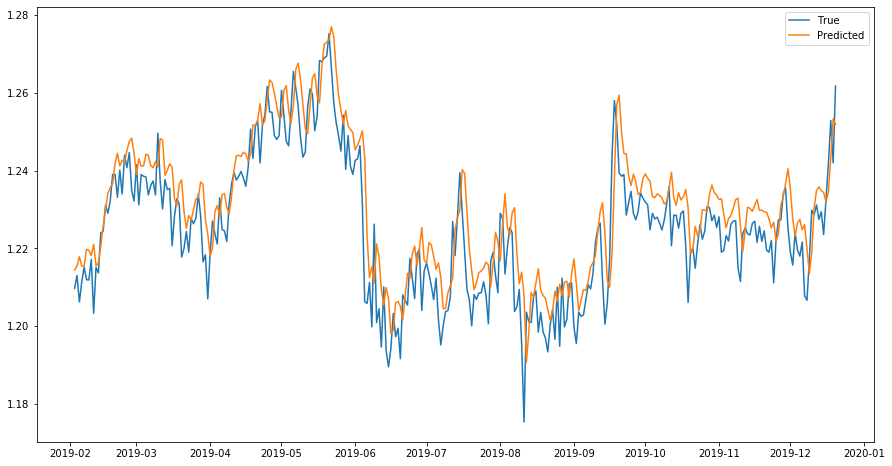

In [28]:
# i have to convert the index back to DatetimeIndex, because otherwise i get an error when plotting
star_day.index = pd.DatetimeIndex(star_day.index.to_timestamp())
test_pre_pd.index = pd.DatetimeIndex(test_pre_pd.index.to_timestamp())
plt.plot(star_day['2019-02-03':'2019-12-20'], label='True')
plt.plot(test_pre_pd, label='Predicted')
plt.legend();

### Good prediction?!?
In the first view the prediction of the test data on the right side in green seems to be very similar to the original data. We will have a closer look inside.

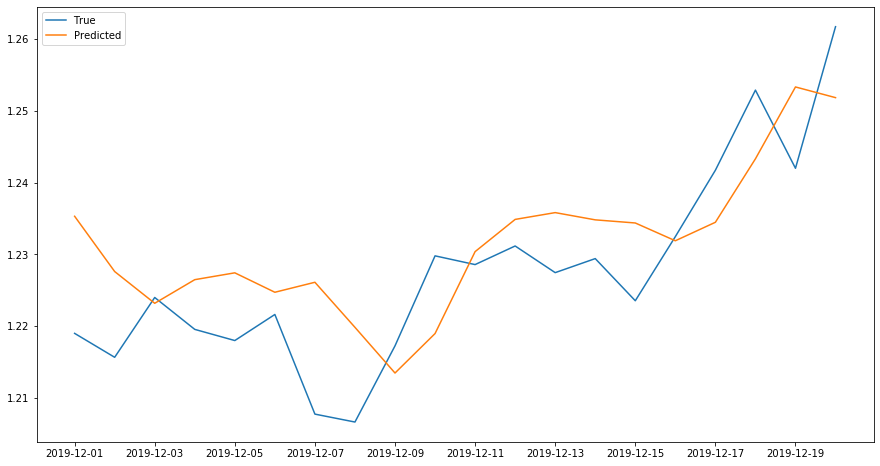

In [29]:
# let's have a closer look at the test data
plt.plot(star_day['2019-12-01':'2019-12-20'], label='True')
plt.plot(test_pre_pd['2019-12-01':'2019-12-20'], label='Predicted')
plt.legend();

The plots shows that the model fits very well even to the test data, but it is more a "follower" than a prediction.

### Predict the whole test data in sequence with own predictions

The LSTM prediction is based on the test data, but i'll want to see if the prediction is also working in a sequence, that means use real start values and the go on with the prediction as new input data. I'll found an example from (Raval, S.)[https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py] and adapted it to my case.

In [33]:
# code adapted from https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
def predict_sequence_full(model, data, window_size):
    print('Predicting sequence...')
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        # predict one step
        predicted.append(model.predict(curr_frame[np.newaxis, :, :])[0,0])
        # add the prediction at the end
        curr_frame = np.insert(curr_frame[0], [window_size], predicted[-1], axis=0)
        # drop the first value, so we have new input for prediction with the last prediction
        curr_frame = curr_frame[np.newaxis, 1:]
    return predicted

# let's predict the test Sequence, but we'll only use the first data set
full_predict = predict_sequence_full(model, testX, 2)

Predicting sequence...


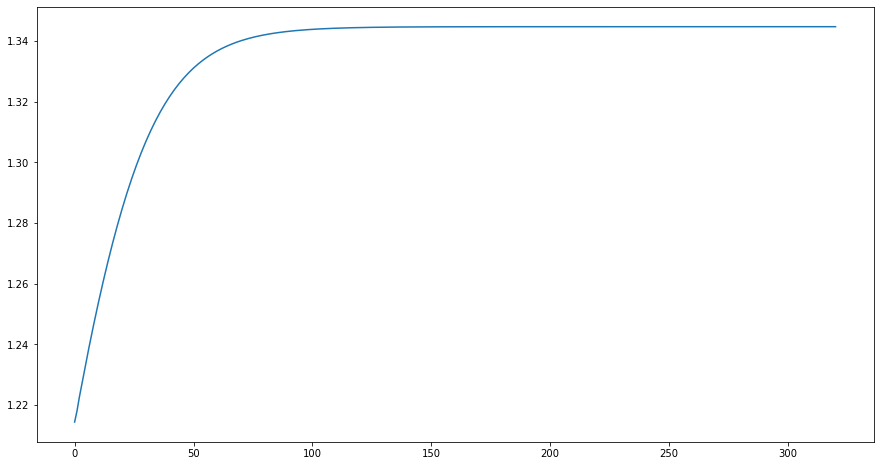

In [34]:
plt.plot(scaler.inverse_transform(np.array(full_predict).reshape(-1,1)));

Here we can see, that a prediction only starting with the first test data set as input value and then forecasting more than one day is not possible with this model. It will come to a limit and not goes up and down like the original data.


# Conclusion and lookout
You'll find the conclusion and lookout in the blog post on [Medium](https://medium.com/@joerg.meisterjahn/forecast-of-fuel-prices-in-germany-7cba2cfd015b)
